<a href="https://colab.research.google.com/github/SergeiSa/Control-Theory-Slides-Spring-2021/blob/main/ColabNotebooks/practice_10_observers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practice 10: State Observers**

---

## **Motivation**

Recall the structure of the all previously derived controllers:
\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}\\
\mathbf{u} = \mathbf{K} \mathbf{x}
\end{cases}
\end{equation}

You may see that control is function of system state $\mathbf{x}$, we call such controllers **full-state** feedback.

However, in most practical cases, the physical state of the system cannot be determined by direct observation. Instead, indirect effects of the internal state are observed by way of the system outputs. 

A simple example is that of vehicles in a tunnel: the rates and velocities at which vehicles enter and leave the tunnel can be observed directly, but the exact state inside the tunnel can only be estimated. If a system is observable, it is possible to fully reconstruct the system state from its output measurements using the state observer.

In many cases the outputs $\mathbf{y} \in \mathbb{R}^{q}$ are given as linear function of states:
\begin{equation}
  \mathbf{y} = \mathbf{C}\mathbf{x}
\end{equation}

where $\mathbf{C}\in \mathbb{R}^{q \times n}$ is so called output matrix. 

Thus the overall system from input $\mathbf{u}$ to output $\mathbf{y}$ is represented as follows:
\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}
\\
\mathbf{y} = \mathbf{C}\mathbf{x}
\end{cases}
\end{equation}


And our goal is to deduce the internal **state** $\mathbf{x}$ by means of **estimates** $\hat{\mathbf{x}}$ using the measurements of **output** $\mathbf{y}$ and knowledge of the system dynamics. To do so we introduce the new system, namely **observer**, which provides the estimate of **states** based on the system output 



<p><img alt="mbk" height="250px" src="https://drive.google.com/uc?id=1C6uRWFLyZmZs19CugJ-kqRhL5Jrjz7WS" align="center" hspace="350px" vspace="0px"></p>



### **Open Loop Observer**

Suppose that somehow you manage to get the initial conditions of the system $\mathbf{x}(0)$, a most straighforward idea is just use the system dynamics in order to advance the state forward in time by solving:
\begin{equation}
\dot{\hat{\mathbf{x}}} = \mathbf{A} \hat{\mathbf{x}} + \mathbf{B} \mathbf{u} 
\end{equation}
starting from $\hat{\mathbf{x}}(0) = \mathbf{x}(0)$, 

Let us simulate this naive aproach. 
As banchmark we will use the cart-pole (inverted pendulum). 

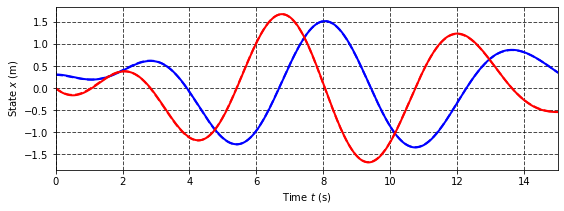

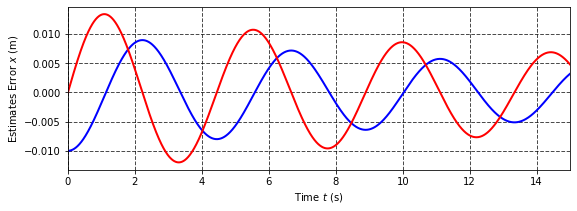

In [ ]:
import numpy as np
from scipy.integrate import odeint

def system_ode(x, t, A, B):
    u = [np.sin(t)]
    dx = np.dot(A,x) + np.dot(B, u)
    return dx

t0 = 0 # Initial time 
tf = 15 # Final time
N = int(2E3) # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

x_real_0 = [0.3, 0] # Set initial state 
x_hat_0 = [0.31, 0] # 

A = [[0, 1], 
     [-2, -0.1]]
A = np.array(A)

B = [[0], 
     [1]]
B = np.array(B)

A_obsv = A

x_real = odeint(system_ode, x_real_0, t, args=(A,B,))
x_hat = odeint(system_ode, x_hat_0, t, args=(A_obsv,B,))


from matplotlib.pyplot import *
y, dy = x_real[:, 0], x_real[:, 1]
y_hat, dy_hat = x_hat[:, 0], x_hat[:, 1]

figure(figsize=(9, 3))
plot(t, y, 'b--', linewidth=2.0)
plot(t, y_hat, 'b', linewidth=2.0)
plot(t, dy, 'r--', linewidth=2.0)
plot(t, dy_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$ (m)')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, y - y_hat, 'b', linewidth=2.0)
plot(t, dy - dy_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimates Error ${x}$ (m)')
xlabel(r'Time $t$ (s)')
show()




### **Closed Loop - Luenberger Observer**
The open loop observer defined amathbfve did not use the knowledge of output $\mathbf{y} = \mathbf{C} \mathbf{x}$. Thus the estimates $\hat{\mathbf{x}}$ may dyverge from the actual state of system $\mathbf{x}$, especially in case when system is unstable, subject to noise, or poorly modeled. instead one may introdece the **correction term** $\mathbf{L}(\mathbf y - \hat{\mathbf y })$ that will compensate for following effects:
\begin{equation}
\hat{\dot {\mathbf{x}}}  = 
\mathbf{A} \hat{\mathbf{x}} + \mathbf{B} \mathbf u + 
\mathbf{L}(\mathbf y - \mathbf{C}\hat{\mathbf x })
\end{equation}
This is so called **Luenberger observer**.

If one will introduce the **estimation error** as $\mathbf{e} = \hat{\mathbf{x}} - \mathbf{x}$ it is easy to show that it will satisfy the following:
\begin{equation}
\dot{\mathbf{e}}= 
(\mathbf{A} - \mathbf{L} \mathbf{C}) 
\mathbf{e}
\end{equation}

Thus if all eigenvalues of matrix $\mathbf{A} - \mathbf{L} \mathbf{C}$ have negative real parts, the estimation error will converge to zero. 
\begin{equation}
\Re\big[\lambda_i(\mathbf{A} - \mathbf{L} \mathbf{C})
\big] < 0, \forall i 
\end{equation}



In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles



def observer_ode(state, t, system_param, observer_params):
    x, x_hat = np.split(state,2)
  
    A = system_param['A']
    B = system_param['B']

    C = observer_params['C']
    L = observer_params['L']
    A_obs = observer_params['A']

    # 
    u = [np.sin(t)]
    # 
    dx = np.dot(A,x) + np.dot(B, u)

    y = np.dot(C, x)
    
    # 
    y_hat = np.dot(C, x_hat)
    e = y -  y_hat
    
    dx_hat = np.dot(A_obs,x_hat) + np.dot(B, u) + np.dot(L, e)
    # print(dx_hat)

    #
    dstate = np.hstack((dx, dx_hat))
    # dstate = dx, dx_hat
    return dstate


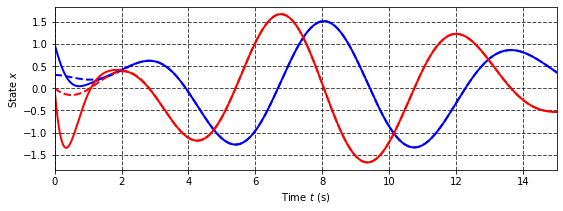

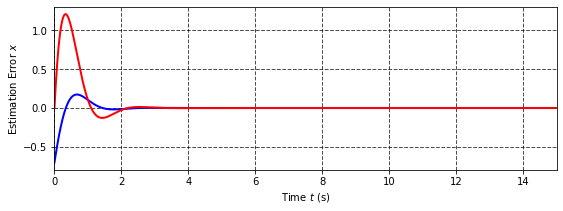

In [ ]:
system_params = {'A':A,'B':B}

A_obs = A 
B_obs = B

C = [[1, 0]]

L = [[4], [10]]
Cov = [0.01]
Cov = np.array(Cov)
observer_params = {'A':A_obs,'C':C, 'L':L}
x_real_0 = [0.3, 0] # Set initial state 
x_hat_0 = [1, 0] # 

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(observer_ode, state_0, t, args=(system_params, observer_params, )) # integrate system "sys_ode" from initial state $x0$

y, dy, y_hat, dy_hat = np.split(state_sol, 4, axis = 1)

figure(figsize=(9, 3))
plot(t, y, 'b--', linewidth=2.0)
plot(t, y_hat, 'b', linewidth=2.0)
plot(t, dy, 'r--', linewidth=2.0)
plot(t, dy_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, y - y_hat, 'b', linewidth=2.0)
plot(t, dy - dy_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimation Error ${x}$')
xlabel(r'Time $t$ (s)')
show()

### **Placing Observer Poles**
<!-- One  -->

Recall that we facing the similar problem while designing the stable feedback controllers: 
\begin{equation}
\dot{\mathbf{x}}= 
(\mathbf{A} - \mathbf{B} \mathbf{K}) 
\mathbf{x}
\end{equation}

Thus, using the fact that characteristical polynomial does not changes when we transpose the matrix we arrive to:
\begin{equation}
\lambda_i(\mathbf{A} - \mathbf{L} \mathbf{C}) = \lambda_i(\mathbf{A}^T - \mathbf{C}^T \mathbf{L}^T)
\end{equation}

and we can use the same techniques that was used for controller design, 


let us begin with pole placement for the inverted pendulum in downwoard position

The linear feedback on the nonlinear system with state $\mathbf{x}=[\theta, \dot{\theta}, x, \dot{x}]^T$ and dynamics given by:

\begin{equation}
\begin{cases} 
\left(M+m\right){\ddot {x}}-m L \ddot{\theta} \cos \theta +m L \dot{\theta }^{2}\sin \theta = u \\
mL^2 \ddot{\theta}- mLg\sin \theta - m L \cos \theta \ddot{x} =  0\\
\end{cases}
\end{equation}

The linearized version nearby the downoward position is given by LTI system with following matrices:
\begin{equation}
\mathbf{A} = 
\begin{bmatrix}
 0 & 1& 0 & 0 \\
 -\frac{g}{L} \frac{(M+m)}{M} & -\frac{b}{ML}& 0 & 0 \\
 0 & 0& 0 & 1 \\
 - g \frac{m}{M} & -\frac{b}{M} & 0 & 0 \\
\end{bmatrix}, \quad
\mathbf{B} = 
\begin{bmatrix}
 0 \\
 -\frac{1}{ML} \\
 0 \\
 \frac{1}{M} \\
\end{bmatrix}
\end{equation}

with state defined as $\mathbf{x} = [ \theta, \dot{\theta}, x, \dot{x} ]^T$




In [ ]:
M, m, l, b, g = 2, .2, 0.2, 0.1, 9.81

A = [[0, 1, 0, 0], 
     [-g*(M+m)/(M*l), 0 , 0, 0],
     [0,0,0,1],
     [-m*g/M, 0, 0,0]]

A = np.array(A)

B = [[0], 
     [-1/(M*l)], 
     [0], 
     [1/M]]

B = np.array(B)

system_params = {'A':A,'B':B}


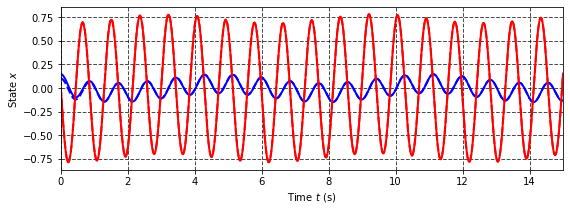

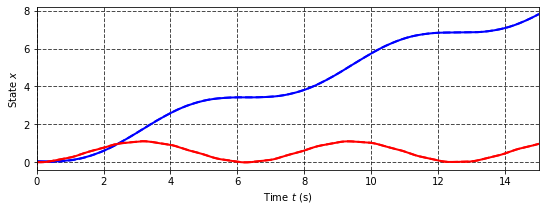

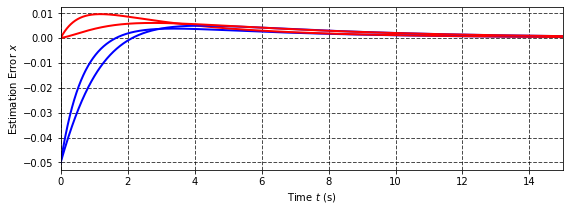

In [ ]:

from scipy.signal import place_poles


A_obs = A 

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

C = np.array(C)

poles = [-0.5, -2, -0.2, -1]
pole_placement = place_poles(A.T, C.T, poles)
L = pole_placement.gain_matrix.T
# print(L)
observer_params = {'A':A_obs,'C':C, 'L':L}

x_real_0 = [0.1, 0, 0, 0] # Set initial state 
x_hat_0 = [0.15, 0, 0.05, 0]

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(observer_ode, state_0, t, args=(system_params, observer_params, )) # integrate system "sys_ode" from initial state $x0$

x_real, x_hat =np.split(state_sol, 2, axis = 1)

theta, dtheta, x, dx = np.split(x_real, 4, axis = 1)

theta_hat, dtheta_hat, x_hat, dx_hat = np.split(x_hat, 4, axis = 1)

figure(figsize=(9, 3))
plot(t, theta, 'b--', linewidth=2.0)
plot(t, theta_hat, 'b', linewidth=2.0)
plot(t, dtheta, 'r--', linewidth=2.0)
plot(t, dtheta_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, x, 'b--', linewidth=2.0)
plot(t, x_hat, 'b', linewidth=2.0)
plot(t, dx, 'r--', linewidth=2.0)
plot(t, dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, theta - theta_hat, 'b', linewidth=2.0)
plot(t, dtheta - dtheta_hat, 'r', linewidth=2.0)
plot(t, x - x_hat, 'b', linewidth=2.0)
plot(t, dx - dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimation Error ${x}$')
xlabel(r'Time $t$ (s)')
show()

### **Closed Loop - Linear Qudratic Estimator**

As soon as one can place the poles of observer at any desired location designing the observer gain can be designed with help of LQR routines, we call such observers Linear Quadratic Estimator (LQE).

In [ ]:
from scipy.linalg import solve_continuous_are as are

def lqr(A, B, Q, R):
    # Solve the ARE
    S = are(A, B, Q, R)
    R_inv = np.linalg.inv(R)
    K = R_inv.dot((B.T).dot(S))
    Ac = A - B.dot(K)
    E = np.linalg.eigvals(Ac)
    return S, K, E

Q_o = 15*np.diag([1,1,1,1])

R_o = np.diag([1,1])

S, LT, E = lqr(A.T, C.T, Q_o, R_o)
L = LT.T

observer_params = {'A':A_obs,'C':C, 'L':L}

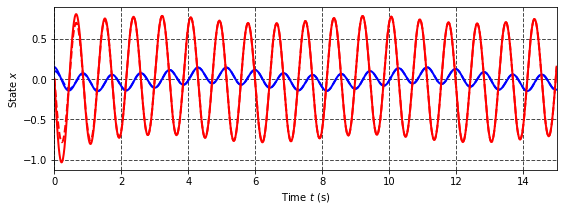

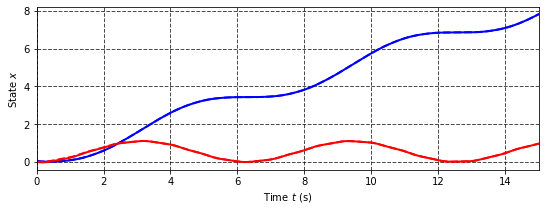

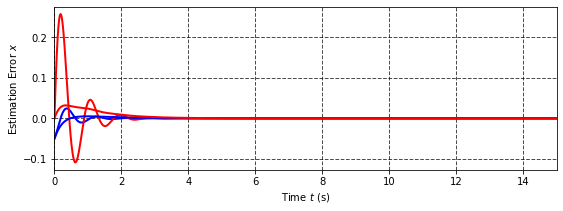

In [ ]:

x_real_0 = [0.1, 0, 0, 0] # Set initial state 
x_hat_0 = [0.15, 0, 0.05, 0]

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(observer_ode, state_0, t, args=(system_params, observer_params, )) # integrate system "sys_ode" from initial state $x0$

x_real, x_hat =np.split(state_sol, 2, axis = 1)

theta, dtheta, x, dx = np.split(x_real, 4, axis = 1)

theta_hat, dtheta_hat, x_hat, dx_hat = np.split(x_hat, 4, axis = 1)

figure(figsize=(9, 3))
plot(t, theta, 'b--', linewidth=2.0)
plot(t, theta_hat, 'b', linewidth=2.0)
plot(t, dtheta, 'r--', linewidth=2.0)
plot(t, dtheta_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, x, 'b--', linewidth=2.0)
plot(t, x_hat, 'b', linewidth=2.0)
plot(t, dx, 'r--', linewidth=2.0)
plot(t, dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, theta - theta_hat, 'b', linewidth=2.0)
plot(t, dtheta - dtheta_hat, 'r', linewidth=2.0)
plot(t, x - x_hat, 'b', linewidth=2.0)
plot(t, dx - dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimation Error ${x}$')
xlabel(r'Time $t$ (s)')
show()

### **Observer Based Control - Separation Principle**
Even though state estimation is interesting problem on it's own the main goal is to use the estimated state inside control loop:
\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} \\
\dot{\hat {\mathbf{x}}} = \mathbf{A} \hat{\mathbf{x}} + \mathbf{B} \mathbf u + \mathbf{L}(\mathbf y - \mathbf{C} \hat{\mathbf{x}})\\
\mathbf{y} = \mathbf{C} \mathbf{x} \\
\mathbf{u} = -\mathbf{K} \hat{\mathbf{x}}
\end{cases}
\end{equation}

One can graphically represented observer-controller connection as follows:

<p><img alt="mbk" height="250px" src="https://drive.google.com/uc?id=1AIlhBXn1tfn3XicCJrnEM3TL2v6hMchz" align="center" hspace="350px" vspace="0px"></p>


Collecting $\dot {\mathbf{x}}$ and $\dot{\mathbf{e}}$ we get:

\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = (\mathbf{A}-\mathbf{B}\mathbf{K}) \mathbf{x} +  \mathbf{B}\mathbf{K}\mathbf{e} \\
\dot{\mathbf{e}} = 
(\mathbf{A}  - \mathbf{L}\mathbf{C})\mathbf{e}
\end{cases}
\end{equation}

In matrix form it becomes:

\begin{equation}
\begin{bmatrix}
\dot {\mathbf{x}} \\
\dot{\mathbf{e}}
\end{bmatrix}
=
\begin{bmatrix}
(\mathbf{A}-\mathbf{B}\mathbf{K}) & \mathbf{B}\mathbf{K} \\
0 & (\mathbf{A}  - \mathbf{L}\mathbf{C})
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{e}
\end{bmatrix}
\end{equation}

Eigenvalues of a upper block-triangular matrices equal to the union of the eigenvalues of the blocks on the main diagonal. Hence here, the eigenvalues of the system are equal to the union of eigenvalues of $(\mathbf{A}-\mathbf{B}\mathbf{K})$ and $(\mathbf{A}  - \mathbf{L}\mathbf{C})$. 


In [ ]:
def observer_controller(state, t, system_param, observer_params):
    x, x_hat = np.split(state,2)
  
    A = system_param['A']
    B = system_param['B']
    K = system_param['K']

    C = observer_params['C']
    L = observer_params['L']
    A_obs = observer_params['A']

    # 
    u = -np.dot(K,x_hat)

    dx = np.dot(A,x) + np.dot(B, u)

    y = np.dot(C, x)
    
    # 
    y_hat = np.dot(C, x_hat)
    e = y -  y_hat
    
    dx_hat = np.dot(A_obs,x_hat) + np.dot(B, u) + np.dot(L, e)
    # print(dx_hat)

    #
    dstate = np.hstack((dx, dx_hat))
    # dstate = dx, dx_hat
    return dstate

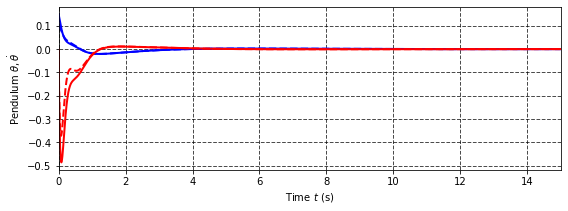

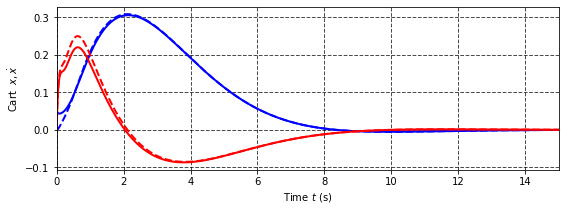

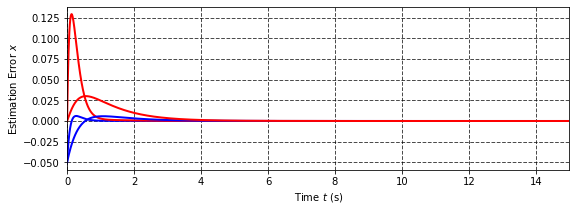

In [ ]:
A = [[0, 1, 0, 0], 
     [g*(M+m)/(M*l), 0 , 0, 0],
     [0,0,0,1],
     [-m*g/M, 0, 0,0]]

A = np.array(A)
A_o = A
Q_c = np.diag([1,1,1,1])
R_c = np.diag([1])

_, K, _ = lqr(A, B, Q_c, R_c)
system_params = {'A':A,'B':B,'K':K}

Q_o = 10*np.diag([1,1,1,1])
R_o = np.diag([1,1])
_, LT, _ = lqr(A_o.T, C.T, Q_o, R_o)
L = LT.T
observer_params = {'A':A_o,'C':C, 'L':L}

state_sol = odeint(observer_controller, state_0, t, args=(system_params, observer_params, )) # integrate system "sys_ode" from initial state $x0$


x_real, x_hat =np.split(state_sol, 2, axis = 1)

theta, dtheta, x, dx = np.split(x_real, 4, axis = 1)

theta_hat, dtheta_hat, x_hat, dx_hat = np.split(x_hat, 4, axis = 1)

figure(figsize=(9, 3))
plot(t, theta, 'b--', linewidth=2.0)
plot(t, theta_hat, 'b', linewidth=2.0)
plot(t, dtheta, 'r--', linewidth=2.0)
plot(t, dtheta_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Pendulum $\theta,\dot{\theta}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, x, 'b--', linewidth=2.0)
plot(t, x_hat, 'b', linewidth=2.0)
plot(t, dx, 'r--', linewidth=2.0)
plot(t, dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Cart  $x,\dot{x}$')
xlabel(r'Time $t$ (s)')
show()

figure(figsize=(9, 3))
plot(t, theta - theta_hat, 'b', linewidth=2.0)
plot(t, dtheta - dtheta_hat, 'r', linewidth=2.0)
plot(t, x - x_hat, 'b', linewidth=2.0)
plot(t, dx - dx_hat, 'r', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimation Error ${x}$')
xlabel(r'Time $t$ (s)')
show()

## **Descrete Time Case**

The design of the observer in the descrete time case is similar to the continues, consider the discrete-time linear system described by:


\begin{equation}
\begin{cases}
\mathbf{x}_{k+1}=\mathbf{A} \mathbf{x}_{k}+\mathbf{B}\mathbf{u}_{k}
\\
\mathbf{y}_k = \mathbf{C}\mathbf{x}_k
\end{cases}
\end{equation}

With the observer given as:
\begin{equation}
\hat{{\mathbf{x}}}_{k+1}  = 
\mathbf{A} \hat{\mathbf{x}}_{k} + \mathbf{B} \mathbf u_{k} + 
\mathbf{L}(\mathbf y_{k} - \mathbf{C}\hat{\mathbf x }_{k})
\end{equation}

It is easy to show that the dynamicsof the estimation error is given by:
\begin{equation}
\mathbf{e}_{k+1} = 
(\mathbf{A}  - \mathbf{L}\mathbf{C})\mathbf{e}_k
\end{equation}
which can be transformed to stable system through placing poles inside the unit circle.

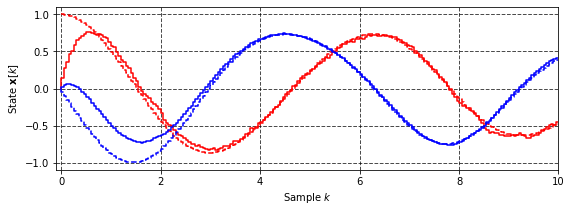

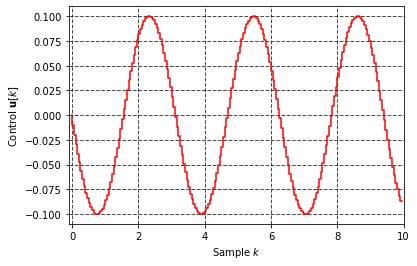

In [ ]:
from scipy.signal import cont2discrete as c2d

T = 0.05
tf = 10
N = int(tf/T)

A = np.array([[0, 1], 
              [-1, -0.1]])

B = np.array([[0], 
              [1]])

C = np.array([[1, 0]])
D = np.array([[0]])

A_d, B_d, C, D, _ = c2d((A,B,C,D), T)
x = np.array([1., 0])
X = x

poles = [0.9, 0.95]
pole_placement = place_poles(A_d.T, C.T, poles)
L = pole_placement.gain_matrix.T

x_hat = np.array([0.0, 0])
X_hat = x_hat
U = []

for k in range(N):
  y = C.dot(x)+ 0.1*np.random.randn(1)
  y_hat = C.dot(x_hat) 
  e = y - y_hat 

  x_hat = A_d.dot(x_hat) + B_d.dot(u) + L.dot(e)

  u = [-np.sin(20*k/N)/10]
  x = A_d.dot(x) + B_d.dot(u)
  U.append(u)

  X = np.vstack((X, x))
  X_hat = np.vstack((X_hat, x_hat))


theta_d, dtheta_d = np.split(X, 2, axis = 1)
theta_e, dtheta_e = np.split(X_hat, 2, axis = 1)


figure(figsize=(9, 3))
step(T*np.arange(N+1),theta_d, 'r--')
step(T*np.arange(N+1),theta_e, 'r')
step(T*np.arange(N+1),dtheta_d, 'b--')
step(T*np.arange(N+1),dtheta_e, 'b')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'State $\mathbf{x}[k]$')
xlabel(r'Sample $k$')
xlim([-0.1, tf])
show()

step(T*np.arange(N),U, 'r')
# plot(T*np.arange(N+1), U, 'r--', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([-0.1, tf])
ylabel(r'Control $\mathbf{u}[k]$')
xlabel(r'Sample $k$')
show()